In [51]:
import cv2
import torch
import urllib.request
import ssl
import numpy as np
from stl import mesh

import matplotlib.pyplot as plt
from transformers import pipeline

In [52]:

ssl._create_default_https_context = ssl._create_unverified_context

In [58]:

def get_depth_map_midas(image_path):
    # code from https://pytorch.org/hub/intelisl_midas_v2/
    # this code is used to get the depth map of the image

    # Load a model
    model_type = "DPT_Large" 
    midas = torch.hub.load("intel-isl/MiDaS", model_type)


    # Load transforms to resize and normalize the image for large or small model
    midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

    if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
        transform = midas_transforms.dpt_transform
    else:
        transform = midas_transforms.small_transform


    # Load image and apply transforms
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    input_batch = transform(img_rgb).to(device)


    # predict and resize to original image size
    with torch.no_grad():
        prediction = midas(input_batch)

        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=img_rgb.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()

    output = prediction.cpu().numpy()
    normalized_depth = (output - output.min()) / (output.max() - output.min())
    plt.imshow(output)
    plt.show()

    return normalized_depth, img_rgb

In [57]:

def get_depth_map_transformer(image_path):
    # https://huggingface.co/tasks/depth-estimation
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    estimator = pipeline(task="depth-estimation", model="Intel/dpt-large")
    result = estimator(images=image_path)
    depth_map = np.array(result["depth"]).astype(np.float32)

    normalized_depth = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())
    return normalized_depth, img_rgb


In [61]:

def fill_inner_area_from_edges(edge_img):
    # Optionally apply a morphological closing to ensure edges are connected
    kernel = np.ones((5, 5), np.uint8)
    closed_edges = cv2.morphologyEx(edge_img, cv2.MORPH_CLOSE, kernel)
    
    # Find contours from the closed edge image
    contours, _ = cv2.findContours(closed_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Create a mask with the same size as the edge image, initially all zeros
    filled_mask = np.zeros_like(edge_img)
    
    # Fill the contours into the mask (all inner areas become white)
    cv2.drawContours(filled_mask, contours, -1, 255, thickness=cv2.FILLED)
    
    return filled_mask


def compute_detail_map(normalized_depth, img_rgb, depth_layer=12):
    # compute the detai map for each layer defined in depth mape

    # Convert image to grayscale for edge detection
    gray_img = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    # Apply global edge detection (using Canny, for example)
    global_edges = cv2.Canny(gray_img, threshold1=50, threshold2=150)
    # Fill inner areas from the global edges
    filled_global = fill_inner_area_from_edges(global_edges)


    # more layers assigned to the closer objects
    power = 2  
    partition_thresholds = np.linspace(0, 1, depth_layer + 1) ** power

    # 2. compute the detail map for each layer base on the depth layer 
    detail_map = []
    for i in range(depth_layer):
        # depth layer that belon
        layer_mask = (normalized_depth >= partition_thresholds[i]) & (normalized_depth < partition_thresholds[i+1])
        layer_detail = np.zeros_like(filled_global, dtype=np.float32)
        layer_detail[layer_mask] = filled_global[layer_mask] / 255.0  
        detail_map.append(layer_detail)
    
    # Combine detail maps from all layers (here we simply average them, but you might want a weighted blend)
    combined_detail_map = np.sum(np.array(detail_map), axis=0)
    
    # For visualization:
    plt.imshow(combined_detail_map, cmap='gray')
    plt.title("Combined Detail Map with Edge Information")
    plt.show()
    
    return combined_detail_map


In [64]:

def create_watertight_mesh(normalized_depth, img_rgb, scale, base_thickness, detail_scale, stl_filename="model.stl"):
    """
    Generates a watertight, 3D-printable mesh.
    - scale: Overall height multiplier (base relief from depth).
    - detail_scale: Fine detail multiplier (extra bumpiness from edges).
    - base_thickness: Thickness of the bottom flat surface.
    """
    H, W = normalized_depth.shape
    
    # Compute the global detail map.
    detail_map = compute_detail_map(normalized_depth, img_rgb)
    
    # Create the height map: base height from depth plus added detail.
    # Here, the GaussianBlur smooths the depth map.
    height_map = cv2.GaussianBlur(normalized_depth, (5, 5), 1.5) * scale  + detail_map * detail_scale
    # only depth map
    # height_map = cv2.GaussianBlur(normalized_depth, (5, 5), 1.5) * scale  
    
    # Generate grid coordinates (each pixel is one unit in x and y).
    xx, yy = np.meshgrid(np.arange(W), np.arange(H))
    
    # Top surface vertices use the height map; bottom surface is a flat plane.
    z_top = height_map.astype(int)
    z_bottom = np.full_like(z_top, -base_thickness)
    
    vertices_top = np.column_stack((xx.ravel(), yy.ravel(), z_top.ravel()))
    vertices_bottom = np.column_stack((xx.ravel(), yy.ravel(), z_bottom.ravel()))
    vertices = np.vstack((vertices_top, vertices_bottom))
    total_vertices = H * W
    
    # Build faces.
    faces = []
    # Top surface (two triangles per grid cell).
    for i in range(H - 1):
        for j in range(W - 1):
            v1 = i * W + j
            v2 = i * W + (j + 1)
            v3 = (i + 1) * W + j
            v4 = (i + 1) * W + (j + 1)
            faces.append([v1, v2, v3])
            faces.append([v3, v2, v4])
    
    # Bottom surface (reverse winding for correct orientation).
    for i in range(H - 1):
        for j in range(W - 1):
            v1 = i * W + j + total_vertices
            v2 = i * W + (j + 1) + total_vertices
            v3 = (i + 1) * W + j + total_vertices
            v4 = (i + 1) * W + (j + 1) + total_vertices
            faces.append([v1, v3, v2])
            faces.append([v3, v4, v2])
    
    # Walls: connect top and bottom surfaces along boundaries.
    # Left wall.
    for i in range(H - 1):
        v_top1 = i * W
        v_top2 = (i + 1) * W
        v_bot1 = v_top1 + total_vertices
        v_bot2 = v_top2 + total_vertices
        faces.append([v_top1, v_top2, v_bot1])
        faces.append([v_top2, v_bot2, v_bot1])
    
    # Right wall.
    for i in range(H - 1):
        v_top1 = i * W + (W - 1)
        v_top2 = (i + 1) * W + (W - 1)
        v_bot1 = v_top1 + total_vertices
        v_bot2 = v_top2 + total_vertices
        faces.append([v_top1, v_bot1, v_top2])
        faces.append([v_top2, v_bot1, v_bot2])
    
    # Front wall (top row).
    for j in range(W - 1):
        v_top1 = j
        v_top2 = j + 1
        v_bot1 = v_top1 + total_vertices
        v_bot2 = v_top2 + total_vertices
        faces.append([v_top1, v_bot1, v_top2])
        faces.append([v_top2, v_bot1, v_bot2])
    
    # Back wall (bottom row).
    for j in range(W - 1):
        v_top1 = (H - 1) * W + j
        v_top2 = (H - 1) * W + j + 1
        v_bot1 = v_top1 + total_vertices
        v_bot2 = v_top2 + total_vertices
        faces.append([v_top1, v_top2, v_bot1])
        faces.append([v_top2, v_bot2, v_bot1])
    
    # Create the STL mesh from the vertices and faces.
    stl_mesh = mesh.Mesh(np.zeros(len(faces), dtype=mesh.Mesh.dtype))
    stl_mesh.vectors = vertices[np.array(faces)]
    
    if not stl_mesh.is_closed():
        raise RuntimeError("Mesh is not watertight")
    
    stl_mesh.save(stl_filename)
    print(f"Successfully generated smooth STL: {stl_filename}")



In [65]:
# ------------------- Main Pipeline -------------------
def generate_printable_model(image_path, scale=150, base_thickness=8, detail_scale = 5,stl_filename="output.stl"):
    # normalized_depth, img_rgb = get_depth_map_midas(image_path)
    normalized_depth, img_rgb = get_depth_map_transformer(image_path)
    create_watertight_mesh(normalized_depth, img_rgb, scale, base_thickness, detail_scale, stl_filename)


Using cache found in /Users/feng/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /Users/feng/.cache/torch/hub/intel-isl_MiDaS_master


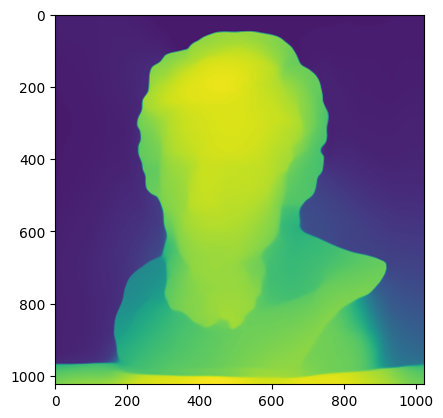

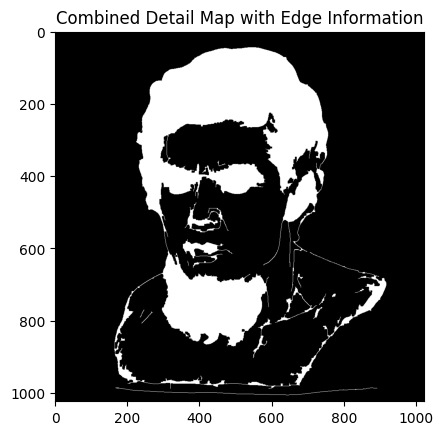

Use of not exact is_closed check. This check can lead to misleading
            results. You could try to use `exact=True`.
            See:
             - false positive: https://github.com/wolph/numpy-stl/issues/198
             - false negative: https://github.com/wolph/numpy-stl/pull/213


Successfully generated smooth STL: model/only_depth/dad_ai.stl


In [49]:

generate_printable_model(
    image_path="image/dad_ai.png", 
    scale=100, 
    base_thickness=10, 
    detail_scale = 10,
    stl_filename="model/only_depth/dad_ai.stl")
